
## Relative Radiometric Correction

### Introduction
The challenge project involves performing a relative radiometric correction using lab and real data captured from one of Open Cosmos's satellites. This work is typical of the tasks you may be expected to carry out in your day to day role.

We do not expect you to spend too much of your personal time on this project, anywhere between 2 - 10 hours. Complete what is possible during this time and do not worry about perfecting the solution.

You are free to use any available open-source software as long as its license allows free commercial use.

There is no restriction about the environment or programming language to be used.

### Objectives
Create a solution that can apply relative radiometric correction to satellite images in order to improve the quality of the image and remove non-uniformities.

- Using the dark and flat field calibration data write code that can create a relative radiometric correction.
- Apply the correction to the lab and real linescan images taking into account the metadata, with the output stored GeoTIFF file.
- Solution should be automated and be able to correct different linescan images based on input parameters.
- Create metrics to show how the quality of the image has changed after applying the correction.


### Expected Output
Candidates are expected to provide the following output:

- Provide the source code created
- Include clear instructions on how to execute the code
- Prepare a short presentation about the solution, approach taken, main challenges and decisions, and the next steps to improve

### Solution
For this coding challenege I have prepared this automated approach that will allow the user to apply a relative radiometric correction to a atartge image using a dark field, and flatfield calibration image

This approach has several steps, which i dealt with by a series of functions, including:
- Import the data
- Correct the image with calibration data 
- Perform data analysis to assess correction 
- Present the data and analysis

In [1]:
# Import Libraries
import numpy as np
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist, squareform

### Functions

### Import data 
Import data using the gdal library, reading the relevant band as a 2D array. The user can determine which band to select using the band argument. 

To process all bands in a multi-band image, I would provide a loop function to process each sequentially. 

In [2]:
# Import raster image function
def rasImport (imgData, band):
    dataImg  = gdal.Open(imgData) 
    band     = dataImg.GetRasterBand(band)
    data     = band.ReadAsArray()
    return data

### Correction Function 
Performs a relative radiometric claibration using reference clibration data, with the following steps. 
- Using the meta data to identify the region within the calibration images that utilise the relevant band filter. 
- These rows are extracted, before the dark field values are subtracted from the flatfield image to remove arroneous illumination
- The corrected flatfield is then normalised by the mean pixel value to ensure that the correction image represents relative variations in sensor response.
- To provide a single response value for each sensor across the push-broom array, each column, representing the components of the aggregated Time Delay Integration (dTDI) capture of the surface is averaged to provide a single value calibration.
- This is multiplied by the number of rows in the target image to povide a single calibration image, the same shape as the target image.
- Before calibration, the target image is normalised by the illumination period, identified in the metadata. 
- The target image is then corrected, by dividing each value by the corresponding value in the correction array.
- Both the original (normalised by illumination period) and corrected images are returned. 
 

In [3]:
# Function to create corrected and normalised image
def corImg (img, meta, darkfield, flatfield):
    global correctionImg
    
    # Get image data
    dataImg  = rasImport(img, 1)
    
    # Get darkfield data
    darkCal  = rasImport(darkfield, 1)
    
    # Get flatfield data
    flatCal  = rasImport(flatfield, 1)

    # Get calibration metadata
    with open(meta, "r") as json_file:
        scanMeta = json.load(json_file)
        
    # extract dark field (filtered band)
    darkCalBand = darkCal[scanMeta['band_start_row']:(scanMeta['band_start_row']+scanMeta['num_tdi'])]

    # extract flat field (filtered band)
    flatCalBand = flatCal[scanMeta['band_start_row']:(scanMeta['band_start_row']+scanMeta['num_tdi'])]

    # Subtract darkfield from flatCalBand
    flatCalBand = flatCalBand-darkCalBand
    
    # Normalise flatfield image by mean pixel value
    flatCalBand = flatCalBand/flatCalBand.mean()
    
    # Normalise target image by exposure duration (in milliseconds)
    dataImg = dataImg/scanMeta['line_period_ms']

    # Average each column (pixel sensor) across the band filter area in the flatfield data (calibrated by dark field)
    flatCalBand = np.mean(flatCalBand, axis=0)

    # Create an array using the flatcalBand mean array (row) repeated by the same number of rows as the target image
    correctionImg = np.tile(flatCalBand, (dataImg.shape[0], 1))
    
    # Correct target image
    correctImg = dataImg/correctionImg
    
    return dataImg, correctImg

### Spatial variagram 
Perform spatial variagram to to ensure that the same spatial characteristics (structure) are preserved before and after correction, using a random selection of points within the image. 

Three variograms are presented, before, after and the difference, each using the same coordinates

In [4]:
# Perform variagram to check spatial consistency in corrected image
def variogram(original, corrected, nSamp):
    global lag_distance_bins
    data = original
    data2 = corrected

    # Define the number of random coordinates to sample
    num_samples = nSamp  # Adjust this value as needed

    # Generate random coordinates within the image dimensions
    sampled_coords = np.zeros((num_samples, 2), dtype=int)
    sampled_coords[:, 0] = np.random.randint(0, data.shape[0], size=num_samples)
    sampled_coords[:, 1] = np.random.randint(0, data.shape[1], size=num_samples)

    # Collect sample values from sample coordinates in each image
    sampled_values1 = data[sampled_coords[:, 0], sampled_coords[:, 1]]
    sampled_values2 = data2[sampled_coords[:, 0], sampled_coords[:, 1]]
    # Calculate pairwise distances for sampled coordinates
    distances = squareform(pdist(sampled_coords))

    # Create a variogram for the pixel value differences between the two images
    n_lags = 10  # Number of lag distances
    lag_distance_bins = np.linspace(0, np.max(distances), n_lags)
    variogram1 = np.zeros(n_lags)
    variogram2 = np.zeros(n_lags)
    variogramD = np.zeros(n_lags)

    for i in range(n_lags):
        lag_bin = lag_distance_bins[i]
        lag_values1 = []
        lag_values2 = []
        lag_valuesD = []
        for j in range(len(sampled_coords)):
            for k in range(j + 1, len(sampled_coords)):
                distance = np.sqrt((sampled_coords[j, 0] - sampled_coords[k, 0]) ** 2 +
                                   (sampled_coords[j, 1] - sampled_coords[k, 1]) ** 2)
                if (distance >= lag_bin and distance < lag_bin + (lag_distance_bins[1] - lag_distance_bins[0])):
                    lag_values1.append((sampled_values1[j] - sampled_values1[k]) ** 2)
                    lag_values2.append((sampled_values2[j] - sampled_values2[k]) ** 2)
                    lag_valuesD.append((sampled_values1[j] - sampled_values2[j]) ** 2)
        if len(lag_values1) > 0:
            variogram1[i] = 0.5 * np.mean(lag_values1)
            variogram2[i] = 0.5 * np.mean(lag_values2)
            variogramD[i] = 0.5 * np.mean(lag_valuesD)
            
    return variogram1, variogram2, variogramD

In [5]:
# Plotting Functions
# Image plot with colour ramp 
def pltCbar (axis, plot, colors, cBar):#,title):  
    im = axis.imshow(plot, cmap = colors)  
    if cBar == True:
        divider = make_axes_locatable(axis)   
        cax = divider.append_axes('right', size='5%', pad=0.05) 
        fig.colorbar(im, cax=cax, orientation='vertical')  
    #axis.set_title(title, fontsize=16, pad = 10)  
    axis.tick_params(labelcolor="k", labelbottom = False, labelleft=False, bottom=False, left=False)
    

# Plot the variogram
def variogramPlt(axis, plot, label):
    im = axis.plot(lag_distance_bins, plot, label=label)
    axis.set_xlabel('Lag Distance')
    axis.set_ylabel('Semivariance')
    axis.legend()
    axis.grid(True)
    # plt.show()

### Correct lab based image

The file locations assume that the user maintains the data structure provided in the challenge, with the working directory set to the base folder of the datafile. 

In [6]:
originalImg, correctedImg = corImg('Data/lab-linescan/B.tiff',"Data/lab-linescan/metadata.json",'Data/calibration/darkfield.tiff', 'Data/calibration/flatfield.tiff')

/srv/conda/envs/notebook/lib/python3.11/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


/tmp/ipykernel_1492/869437535.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1)


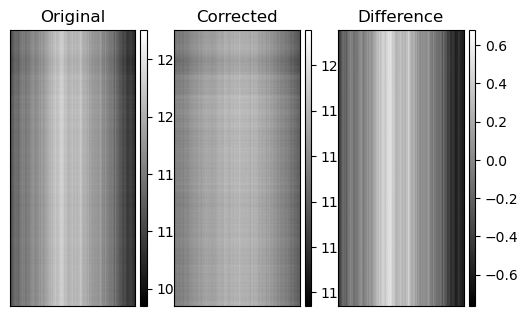

In [7]:
# Plot the original and corrected images
diffImg = originalImg-correctedImg
plots = [originalImg, correctedImg,diffImg]
titles = ['Original', 'Corrected', 'Difference']
# Define subplot shape (height, width)
plotShape = (1, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6,5))
# Start loop count
count = 0

# Loop through columns and rows of subplots
for x in range(plotShape[0]):
    for y in range(plotShape[1]):
    
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        pltCbar(ax,plots[count], 'gray', True) 
        ax.set_title(titles[count])
        count +=1

#### Check quality of lab based correction 
Check how the variance has changed in the reference (lab) based image using the satandard deveiation, with a lower standdarad deviation (while maintaining the same mean) the target. This will be demonstrated with a narrower peak (lower variance) about the mean in the histogram.  

Original mean and standard deviation 11.634 0.412
Corrected mean and standard deviation 11.632 0.136


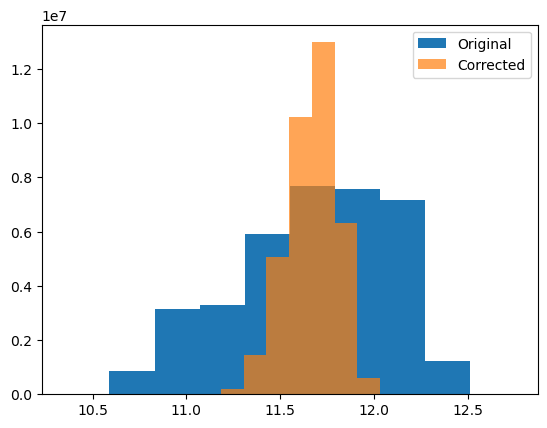

In [8]:
# correction based on sensor row mean and variance, and image histogram
print('Original mean and standard deviation', round(originalImg[1,:].mean(), 3),  round(originalImg[1,:].std(),3))
print('Corrected mean and standard deviation', round(correctedImg[1,:].mean(),3),  round(correctedImg[1,:].std(),3))

plt.hist(originalImg.flatten(),bins = 10, label = 'Original')
plt.hist(correctedImg.flatten(),bins = 10, alpha = 0.7, label= 'Corrected')
plt.legend()
plt.show()

### Correct sample satellite image

Again, the file locations assume that the user maintains the data structure provided in the challenge, with the working directory set to the base folder of the datafile. 


In [9]:
originalImg, correctedImg = corImg('Data/real-linescan/B.tiff',"Data/real-linescan/metadata.json",'Data/calibration/darkfield.tiff', 'Data/calibration/flatfield.tiff')

/tmp/ipykernel_1492/2689043604.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1)


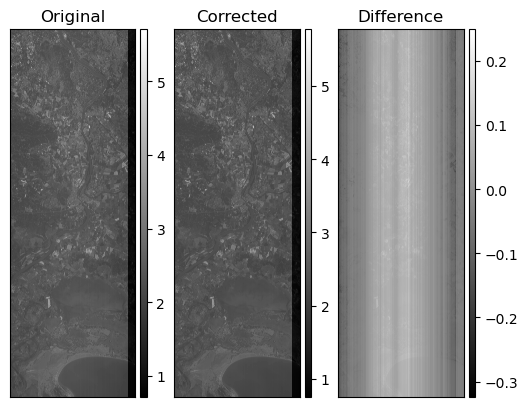

In [10]:
# Plot the original and corrected images, with the difference rerpresenting the change in values due tot he correction
diffImg = originalImg-correctedImg
plots = [originalImg, correctedImg,diffImg]
titles = ['Original', 'Corrected', 'Difference']
# Define subplot shape (height, width)
plotShape = (1, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(6,5))
# Start loop count
count = 0

# Loop through columns and rows of subplots
for x in range(plotShape[0]):
    for y in range(plotShape[1]):
    
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        ax.set_title(titles[count])
        pltCbar(ax,plots[count], 'gray', True) 
        count +=1

#### Check spatial consistency of corrected image with variagram  

Comapre the variagrams between the two images, which should show some change, but only limited. Too large a change sugests the fundemental surface reflectance has been erroneously altered. 

In [11]:
V1, V2, V3 = variogram(originalImg, correctedImg, 150)

/tmp/ipykernel_1492/4205087244.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1)


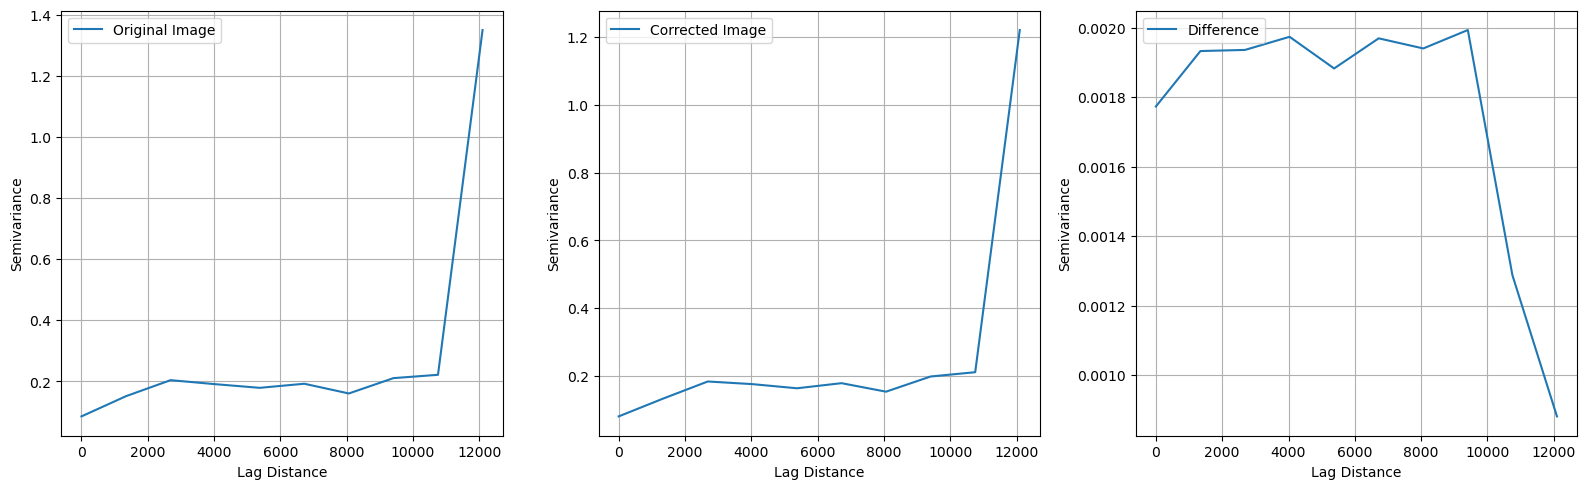

In [12]:
plots = [V1, V2, V3]
labels = ['Original Image', 'Corrected Image', 'Difference']
# Define subplot shape (height, width)
plotShape = (1, 3)
# Define plot size
fig, ax = plt.subplots(figsize=(16,5))
# Start loop count
count = 0

# Loop through columns and rows of subplots
for x in range(plotShape[0]):
    for y in range(plotShape[1]):
    
        # Subplot description
        ax    = plt.subplot2grid((plotShape), (x, y), colspan=1, rowspan=1) 
        variogramPlt(ax, plots[count], labels[count])
        count +=1
plt.tight_layout()
